In [2]:
# MODEL DEFINITION
import collections
import itertools
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode
from scipy.spatial.distance import squareform
import sys

plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False


class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays

    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN

    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function

    subsample_step : int, optional (default = 1)
        Step size for the time series array. By setting subsample_step = 2,
        the time series length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """

    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step

    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels

        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer

        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """

        self.x = x
        self.l = l

    def _dtw_distance(self, ts_a, ts_b, d=lambda x, y: abs(x - y)):
        """Returns the DTW similarity distance between two 2-D
        time series numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of time series data
            whose DTW distance between each sample of A and B
            will be compared

        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function

        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i - 1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j - 1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j - 1], cost[i - 1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window
        return cost[-1, -1]

    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure

        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]

        y : array of shape [n_samples, n_timepoints]

        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """

        # Compute the distance matrix
        dm_count = 0

        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if (np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)

            p = ProgressBar(dm.shape[0])

            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])

                    dm_count += 1
                    p.animate(dm_count)

            # Convert to squareform
            dm = squareform(dm)
            return dm

        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0]))
            dm_size = x_s[0] * y_s[0]

            p = ProgressBar(dm_size)

            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)

            return dm

    def predict(self, x):
        """Predict the class labels or probability estimates for
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified

        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels
              (2) the knn label count probability
        """

        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]

        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1] / self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()


class ProgressBar:
    """This progress bar was taken from PYMC"""

    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print('\r', self)
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

In [25]:
# IMPORTING MODULES
import os
import matplotlib.pyplot as plt
import sktime
import sys
module_path = os.path.abspath(os.path.join('..', 'src'))
sys.path.append(module_path)

from keras.utils import pad_sequences
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier as Knn_Dtw

In [26]:
# MODEL PARAMETERS
# max_warping_window = 10
# knn_dtw = KnnDtw(n_neighbors=1, max_warping_window=max_warping_window, subsample_step=2)
knn_dtw = Knn_Dtw()

In [70]:
# TRAIN KNN-DTW MODEL - ECG BASELINE REST
TYPE = "ECG BASELINE REST"
CONVERT_SR = True
# CONVERT_SR = False

import glob
import os
import numpy as np
import pandas as pd
import tools.data_reader as dr

ROOT_DIR = "C:\\Users\\zhoux\\Desktop\\Projects\\anxiety"
TOOLS_DIR = os.path.join(ROOT_DIR, "tools")

import sys
sys.path.append(TOOLS_DIR)
import importlib
from tools import data_reader as dr
importlib.reload(dr)

from sklearn.model_selection import train_test_split


HA_BASELINES = dr.get_dataframes_from_files(
    glob.glob(dr.Paths.PARTICIPANT_DATA_DIR + "\\" + dr.Groups.HA + "\\*\\baseline\\Heart_Baseline_Rest.csv")
)
LA_BASELINES = dr.get_dataframes_from_files(
    glob.glob(dr.Paths.PARTICIPANT_DATA_DIR + "\\" + dr.Groups.LA + "\\*\\baseline\\Heart_Baseline_Rest.csv")
)
# get rid of timestamp and heading
HA_BASELINES = [df.iloc[1:, 1] for df in HA_BASELINES]
LA_BASELINES = [df.iloc[1:, 1] for df in LA_BASELINES]
HA_BASELINES = pd.concat(HA_BASELINES, axis=1)
LA_BASELINES = pd.concat(LA_BASELINES, axis=1)
HA_BASELINES = HA_BASELINES.fillna(0.0).to_numpy()
LA_BASELINES = LA_BASELINES.fillna(0.0).to_numpy()
num_samples_ha = HA_BASELINES.shape[1]
num_samples_la = LA_BASELINES.shape[1]

if CONVERT_SR:
    HA_BASELINES = [samplerate.resample(HA_BASELINES[:, i], ratio=100.0/250.0) for i in range(num_samples_ha)]
    LA_BASELINES = [samplerate.resample(LA_BASELINES[:, i], ratio=100.0/250.0) for i in range(num_samples_la)]
    HA_BASELINES = np.vstack(HA_BASELINES)
    LA_BASELINES = np.vstack(LA_BASELINES)
    x_train = np.vstack([HA_BASELINES, LA_BASELINES])
else:
    x_train = np.hstack([HA_BASELINES, LA_BASELINES])
    x_train = np.transpose(x_train)

# print(x_train.shape)
x_train = x_train.astype(np.float32)
y_train = [1 for _ in range(num_samples_ha)] + [0 for _ in range(num_samples_la)]
y_train = np.asarray(y_train)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=16)

In [88]:
# TRAIN KNN-DTW MODEL - ECG BASELINE SPEECH
TYPE = "ECG BASELINE SPEECH"
CONVERT_SR = True
# CONVERT_SR = False

import glob
import os
import numpy as np
import pandas as pd
import tools.data_reader as dr

ROOT_DIR = "C:\\Users\\zhoux\\Desktop\\Projects\\anxiety"
TOOLS_DIR = os.path.join(ROOT_DIR, "tools")

import sys
sys.path.append(TOOLS_DIR)
import importlib
from tools import data_reader as dr
importlib.reload(dr)

from sklearn.model_selection import train_test_split


HA_BASELINES = dr.get_dataframes_from_files(
    glob.glob(dr.Paths.PARTICIPANT_DATA_DIR + "\\" + dr.Groups.HA + "\\*\\baseline\\Heart_Baseline_Speech.csv")
)
LA_BASELINES = dr.get_dataframes_from_files(
    glob.glob(dr.Paths.PARTICIPANT_DATA_DIR + "\\" + dr.Groups.LA + "\\*\\baseline\\Heart_Baseline_Speech.csv")
)
# get rid of timestamp and heading
HA_BASELINES = [df.iloc[1:, 1] for df in HA_BASELINES]
LA_BASELINES = [df.iloc[1:, 1] for df in LA_BASELINES]
HA_BASELINES = pd.concat(HA_BASELINES, axis=1)
LA_BASELINES = pd.concat(LA_BASELINES, axis=1)
HA_BASELINES = HA_BASELINES.fillna(0.0).to_numpy()
LA_BASELINES = LA_BASELINES.fillna(0.0).to_numpy()
num_samples_ha = HA_BASELINES.shape[1]
num_samples_la = LA_BASELINES.shape[1]

if CONVERT_SR:
    HA_BASELINES = [samplerate.resample(HA_BASELINES[:, i], ratio=100.0/250.0) for i in range(num_samples_ha)]
    LA_BASELINES = [samplerate.resample(LA_BASELINES[:, i], ratio=100.0/250.0) for i in range(num_samples_la)]
    HA_BASELINES = np.vstack(HA_BASELINES)
    LA_BASELINES = np.vstack(LA_BASELINES)
    HA_BASELINES = np.transpose(HA_BASELINES)
    LA_BASELINES = np.transpose(LA_BASELINES)
    # print(HA_BASELINES.shape)
    # print(LA_BASELINES.shape)

x_train = pad_sequences([HA_BASELINES, LA_BASELINES], padding="post")
x_train = np.hstack([x_train[0, :, :], x_train[1, :, :]])
x_train = np.transpose(x_train)

# print(x_train.shape)
x_train = x_train.astype(np.float32)
y_train = [1 for _ in range(num_samples_ha)] + [0 for _ in range(num_samples_la)]
y_train = np.asarray(y_train)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=16)

(52, 16201)


In [94]:
# TRAIN KNN-DTW MODEL - EDA BASELINE REST
TYPE = "EDA BASELINE REST"
# CONVERT_SR = True
CONVERT_SR = False

import glob
import os
import numpy as np
import pandas as pd
import tools.data_reader as dr

ROOT_DIR = "C:\\Users\\zhoux\\Desktop\\Projects\\anxiety"
TOOLS_DIR = os.path.join(ROOT_DIR, "tools")

import sys
sys.path.append(TOOLS_DIR)
import importlib
from tools import data_reader as dr
importlib.reload(dr)

from sklearn.model_selection import train_test_split


HA_BASELINES = dr.get_dataframes_from_files(
    glob.glob(dr.Paths.PARTICIPANT_DATA_DIR + "\\" + dr.Groups.HA + "\\*\\baseline\\EDA_Baseline_Rest.csv")
)
LA_BASELINES = dr.get_dataframes_from_files(
    glob.glob(dr.Paths.PARTICIPANT_DATA_DIR + "\\" + dr.Groups.LA + "\\*\\baseline\\EDA_Baseline_Rest.csv")
)
# get rid of timestamp and heading
HA_BASELINES = [df.iloc[1:, 1] for df in HA_BASELINES]
LA_BASELINES = [df.iloc[1:, 1] for df in LA_BASELINES]
HA_BASELINES = pd.concat(HA_BASELINES, axis=1)
LA_BASELINES = pd.concat(LA_BASELINES, axis=1)
HA_BASELINES = HA_BASELINES.fillna(0.0).to_numpy()
LA_BASELINES = LA_BASELINES.fillna(0.0).to_numpy()
num_samples_ha = HA_BASELINES.shape[1]
num_samples_la = LA_BASELINES.shape[1]

if CONVERT_SR:
    HA_BASELINES = [samplerate.resample(HA_BASELINES[:, i], ratio=100.0/250.0) for i in range(num_samples_ha)]
    LA_BASELINES = [samplerate.resample(LA_BASELINES[:, i], ratio=100.0/250.0) for i in range(num_samples_la)]
    HA_BASELINES = np.vstack(HA_BASELINES)
    LA_BASELINES = np.vstack(LA_BASELINES)
    HA_BASELINES = np.transpose(HA_BASELINES)
    LA_BASELINES = np.transpose(LA_BASELINES)
    # print(HA_BASELINES.shape)
    # print(LA_BASELINES.shape)

x_train = pad_sequences([HA_BASELINES, LA_BASELINES], padding="post")
x_train = np.hstack([x_train[0, :, :], x_train[1, :, :]])
x_train = np.transpose(x_train)

print(x_train.shape)
x_train = x_train.astype(np.float32)
y_train = [1 for _ in range(num_samples_ha)] + [0 for _ in range(num_samples_la)]
y_train = np.asarray(y_train)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=16)

(52, 7942)


In [98]:
# TRAIN KNN-DTW MODEL - EDA BASELINE SPEECH
TYPE = "EDA BASELINE SPEECH"
# CONVERT_SR = True
CONVERT_SR = False

import glob
import os
import numpy as np
import pandas as pd
import tools.data_reader as dr

ROOT_DIR = "C:\\Users\\zhoux\\Desktop\\Projects\\anxiety"
TOOLS_DIR = os.path.join(ROOT_DIR, "tools")

import sys
sys.path.append(TOOLS_DIR)
import importlib
from tools import data_reader as dr
importlib.reload(dr)

from sklearn.model_selection import train_test_split


HA_BASELINES = dr.get_dataframes_from_files(
    glob.glob(dr.Paths.PARTICIPANT_DATA_DIR + "\\" + dr.Groups.HA + "\\*\\baseline\\EDA_Baseline_Speech.csv")
)
LA_BASELINES = dr.get_dataframes_from_files(
    glob.glob(dr.Paths.PARTICIPANT_DATA_DIR + "\\" + dr.Groups.LA + "\\*\\baseline\\EDA_Baseline_Speech.csv")
)
# get rid of timestamp and heading
HA_BASELINES = [df.iloc[1:, 1] for df in HA_BASELINES]
LA_BASELINES = [df.iloc[1:, 1] for df in LA_BASELINES]
HA_BASELINES = pd.concat(HA_BASELINES, axis=1)
LA_BASELINES = pd.concat(LA_BASELINES, axis=1)
HA_BASELINES = HA_BASELINES.fillna(0.0).to_numpy()
LA_BASELINES = LA_BASELINES.fillna(0.0).to_numpy()
num_samples_ha = HA_BASELINES.shape[1]
num_samples_la = LA_BASELINES.shape[1]

if CONVERT_SR:
    HA_BASELINES = [samplerate.resample(HA_BASELINES[:, i], ratio=100.0/250.0) for i in range(num_samples_ha)]
    LA_BASELINES = [samplerate.resample(LA_BASELINES[:, i], ratio=100.0/250.0) for i in range(num_samples_la)]
    HA_BASELINES = np.vstack(HA_BASELINES)
    LA_BASELINES = np.vstack(LA_BASELINES)
    HA_BASELINES = np.transpose(HA_BASELINES)
    LA_BASELINES = np.transpose(LA_BASELINES)
    # print(HA_BASELINES.shape)
    # print(LA_BASELINES.shape)

x_train = pad_sequences([HA_BASELINES, LA_BASELINES], padding="post")
x_train = np.hstack([x_train[0, :, :], x_train[1, :, :]])
x_train = np.transpose(x_train)

print(x_train.shape)
x_train = x_train.astype(np.float32)
y_train = [1 for _ in range(num_samples_ha)] + [0 for _ in range(num_samples_la)]
y_train = np.asarray(y_train)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=16)

(52, 8192)


In [99]:
# TRAIN KNN-DTW
print(f"Training on: {TYPE}")
knn_dtw.fit(x_train, y_train)

Training on: EDA BASELINE SPEECH


KNeighborsTimeSeriesClassifier()

In [100]:
# PREDICT USING KNN-DTW
preds = knn_dtw.predict_proba(x_test)
preds = np.argmax(preds, axis=1)
print(preds)
print(y_test)

[1 1 1 1 0 1]
[1 0 1 0 1 1]


              precision    recall  f1-score   support

          LA       0.00      0.00      0.00         1
          HA       0.75      0.60      0.67         5

    accuracy                           0.50         6
   macro avg       0.38      0.30      0.33         6
weighted avg       0.62      0.50      0.56         6



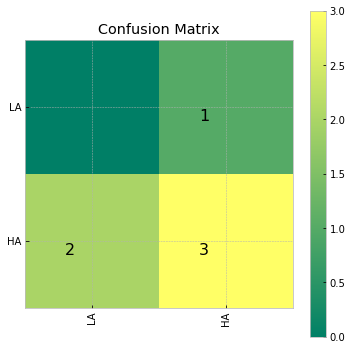

In [101]:
from sklearn.metrics import classification_report, confusion_matrix


def display_confusion_matrix(labels, preds, y_test):
    print(
        classification_report(preds, y_test,
        target_names=[l for l in labels.values()])
    )

    conf_mat = confusion_matrix(preds, y_test)

    fig = plt.figure(figsize=(6,6))
    width = np.shape(conf_mat)[1]
    height = np.shape(conf_mat)[0]

    res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
    for i, row in enumerate(conf_mat):
        for j, c in enumerate(row):
            if c>0:
                plt.text(j-.2, i+.1, c, fontsize=16)
                
    cb = fig.colorbar(res)
    plt.title('Confusion Matrix')
    _ = plt.xticks(range(2), [l for l in labels.values()], rotation=90)
    _ = plt.yticks(range(2), [l for l in labels.values()])


labels = {0: "LA", 1: "HA"}
display_confusion_matrix(labels, preds, y_test)

(7942, 26)


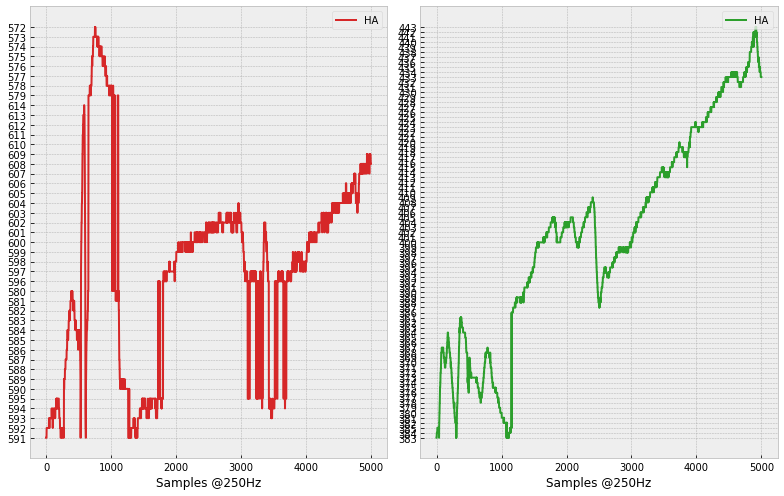

In [21]:
# PLOT DATA
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']
labels = {0: "LA", 1: "HA"}

# CHECK SHAPE
print(HA_BASELINES.shape)

plt.figure(figsize=(11,7))
# for i, r in enumerate([0, 2, 3, 12, 17, 19, 23, 44, 45]):
for i, r in enumerate([0, 2]):
    # plt.subplot(3, 3, i+1)
    plt.subplot(1, 2, i+1)
    start = 0
    stop = 5000
    x = list(range(start, stop))
    plt.plot(x, HA_BASELINES[start:stop, r], label=labels[1], color=colors[i], linewidth=2)
    plt.xlabel('Samples @250Hz')
    plt.legend(loc='upper right')
    plt.tight_layout()